In [4]:
import math
import scipy
import numpy as np
import matplotlib.pyplot as plt
import torch 
from typing import List

/home/nemo/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def discrete_gaussian_kernel(t, n):
    return math.exp(-t) * scipy.special.iv(n, t)

In [7]:
def get_gaussian_diff_kernel(t, ns: int):
        # create and return the parater used as sigma.
        sigma = torch.tensor(t)
        ns = torch.tensor(list(ns))
        exponent = - 0.5 * (ns / max(sigma,0.01)) * (ns / max(sigma,0.01))
        kernel = 1/max(sigma*math.sqrt(2*math.pi), 1) * torch.exp(exponent)
        return kernel

In [8]:
def plot_kernel(ts: List[float], n: int, kernel):
    assert(n%2 == 1)
    ns = range(-(n//2), n//2+1)
    print(ns)
    ys = [kernel(t, ns) for t in ts]
    plt.plot(*(ns if k%2==0 else ys[k//2] for k in range(len(ts)*2)))
    plt.xlim([-n//2, n//2+1])
    plt.ylim([0, 1])

range(-5, 6)


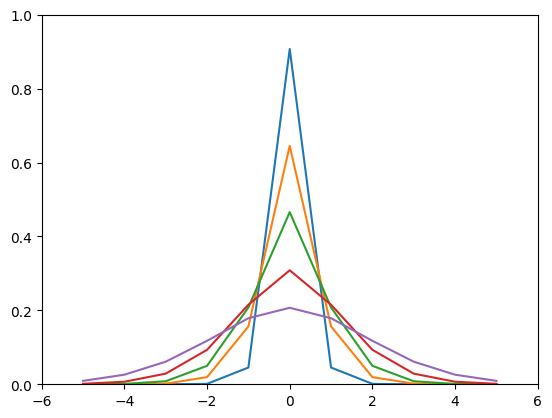

In [9]:
plot_kernel([0.1, 0.5, 1,2,4], 11, discrete_gaussian_kernel)

range(-10, 11)


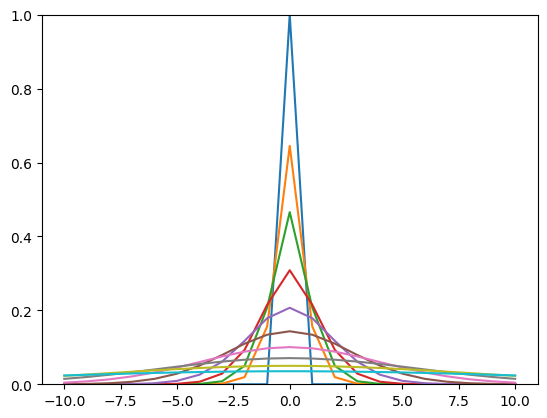

In [10]:
plot_kernel([0, 0.5, 1,2,4,8, 16, 32, 64, 128], 21, discrete_gaussian_kernel)

range(-5, 6)


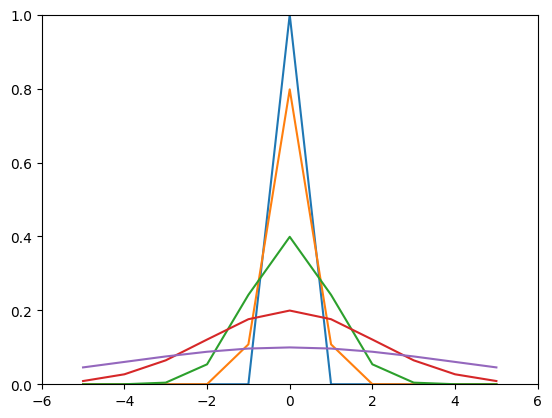

In [12]:
plot_kernel([0.1, 0.5, 1,2,4], 11, get_gaussian_diff_kernel)

range(-10, 11)


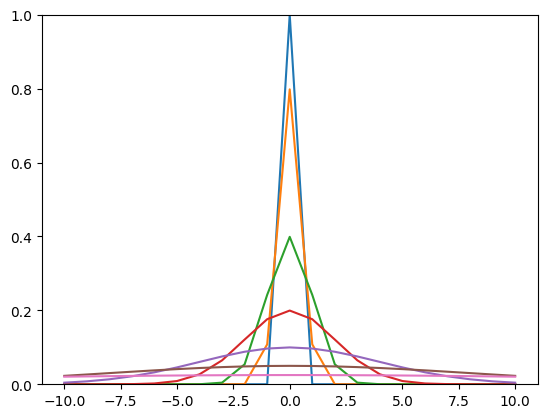

In [18]:
plot_kernel([0, 0.5, 1,2,4,8, 16], 21, get_gaussian_diff_kernel)

In [19]:
def combined_Kernel(t,ns):
    kernels = torch.stack(tuple(get_gaussian_diff_kernel(t * 2**i, ns) for i in range(5)))
    kernels = torch.mean(kernels, dim=0)
    return kernels

range(-10, 11)


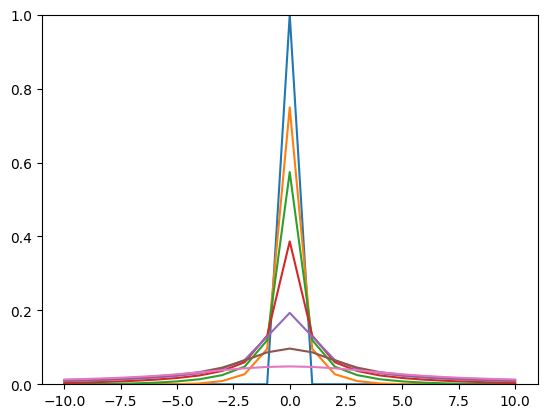

In [24]:
plot_kernel([0, 0.1 , 0.2, 0.4, 0.8, 1.6, 3.2], 21, combined_Kernel)